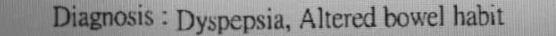

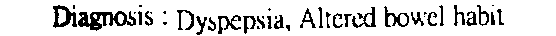

[[0 1 0]
 [1 1 1]
 [0 1 0]]


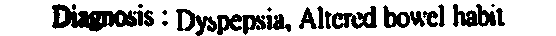

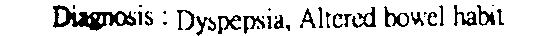

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# mport cv2.cv as cv
img = cv2.imread('./images/29.png')
GrayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
display(Image.fromarray(GrayImage))
ret, thresh1 = cv2.threshold(GrayImage, 110, 255, cv2.THRESH_BINARY)
display(Image.fromarray(thresh1))
# ret,thresh2=cv2.threshold(GrayImage,130,255,cv2.THRESH_BINARY_INV)
kernel = np.uint8(np.zeros((3, 3)))
kernel[1][1] = 1
kernel[0][1] = 1
kernel[1][0] = 1
kernel[1][2] = 1
kernel[2][1] = 1

# for x in range(3):
#     kernel[x, 2] = 1
#     kernel[2, x] = 1
print(kernel)
# 腐蚀图像
eroded = cv2.erode(thresh1, kernel)
display(Image.fromarray(eroded))

# display(Image.fromarray(255 - eroded))

# 膨胀图像
dilated = cv2.dilate(eroded, kernel)

display(Image.fromarray(dilated))


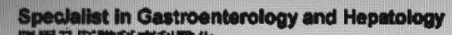

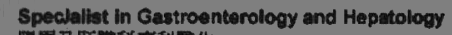

./images/3_.png
Specialist in Gastroenterology and Hepatology


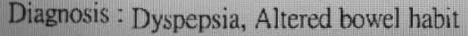

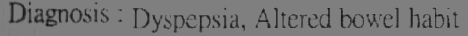

./images/29_.png
Diagnosis : Dyspepsia, Altered bowel habit


./images/13_.png
Doctor


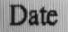

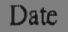

./images/25_.png
Date


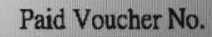

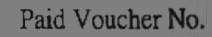

./images/24_.png
Paid Voucher No.


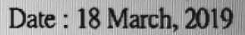

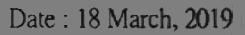

./images/12_.png
Date : 18 March, 2019


./images/28_.png
18 Mar, 2019


./images/2_.png
1 Pedder St, Central


./images/9_.png
FHKAM(Medicina) MSc(Health and Hospital Mgt)(Birm)


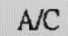

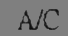

./images/23_.png
A/C


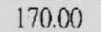

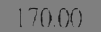

./images/19_.png
170.00


./images/5_.png
hong Kong


./images/15_.png
Amount


./images/14_.png
Patient Code


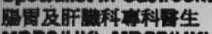

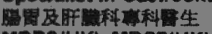

./images/4_.png
RS SR


./images/18_.png
MEDICATION


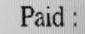

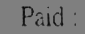

./images/22_.png
Paid :


./images/8_.png
Fax : 2530 0639


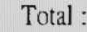

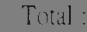

./images/21_.png
Total :


./images/17_.png
~ 170.00


./images/7_.png
MBBS(HK) MRCP(UK) FRCP(Edin) FHKCP


./images/6_.png
Tel : 2530 0633


./images/16_.png
Ttems


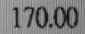

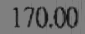

./images/20_.png
170.00


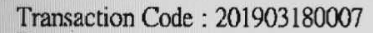

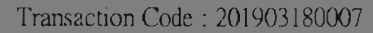

./images/11_.png
Transaction Code :; 201903180007


./images/1_.png
Room 529, Central Building


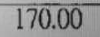

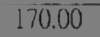

./images/27_.png
170.00


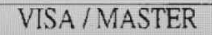

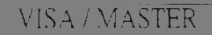

./images/26_.png
VISA / MASTER


./images/0_.png
eed


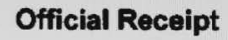

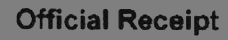

./images/10_.png
Official Receipt


In [89]:
from glob import glob
import pytesseract

paths = glob('./images/*_.png')

def process_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     display(img)
    
    arr = (img // 10)*10 
    counts = np.bincount(arr.flatten())
#     print(np.argmax(counts))
    
    display(Image.fromarray(img))
    
#     ret, thresh1 = cv2.threshold(img, 40, 255, cv2.THRESH_BINARY)
    ret, thresh1 = cv2.threshold(img, 127, 255, cv2.THRESH_TRUNC)
    
    img = Image.fromarray(thresh1)
    display(img)
    return img

for p in paths:
    image = process_img(p)
    print(p)
    text = pytesseract.image_to_string(image, config='-l eng --oem 3 --psm 7 -c load_system_dawg=0 -c load_freq_dawg=0')
    print(text)

In [14]:
# 以 ~ | — _ 空格 开头结尾的都可以去除
# adjust调整False，然后扩展两个像素点


Help on built-in function threshold:

threshold(...)
    threshold(src, thresh, maxval, type[, dst]) -> retval, dst
    .   @brief Applies a fixed-level threshold to each array element.
    .   
    .   The function applies fixed-level thresholding to a multiple-channel array. The function is typically
    .   used to get a bi-level (binary) image out of a grayscale image ( #compare could be also used for
    .   this purpose) or for removing a noise, that is, filtering out pixels with too small or too large
    .   values. There are several types of thresholding supported by the function. They are determined by
    .   type parameter.
    .   
    .   Also, the special values #THRESH_OTSU or #THRESH_TRIANGLE may be combined with one of the
    .   above values. In these cases, the function determines the optimal threshold value using the Otsu's
    .   or Triangle algorithm and uses it instead of the specified thresh.
    .   
    .   @note Currently, the Otsu's and Triangle methods a